<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ShuaiGuo16/Surrogate_Optimization/blob/master/Surrogate_Optimization.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
  </td>
</table>

# Surrogate Optimization

In this notebook, we will use a surrogate optimization approach to locate the global minimum of a test function. For the current case study, a **Gaussian Process** (GP) model is adopted as the surrgate model.

To understand more about the intuition of the surrogate optimization approach, please check out the companion blog:

[An Introduction To Surrogate Optimization: Intuition, illustration, case study, and the code](https://towardsdatascience.com/an-introduction-to-surrogate-optimization-intuition-illustration-case-study-and-the-code-5d9364aed51b?sk=cf62f0cb9fbf0aa8cde65a515e21c1e4)

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import scipy.stats as st
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)

### Test Function
For the demonstration purpose, we assume the true underlying test function is:

\begin{equation}
f(x) = (6x-2)^2 sin(12x-4), \; x \in [0, 1]
\end{equation}

We can visually identify the global minimum of this test function by plotting it out.

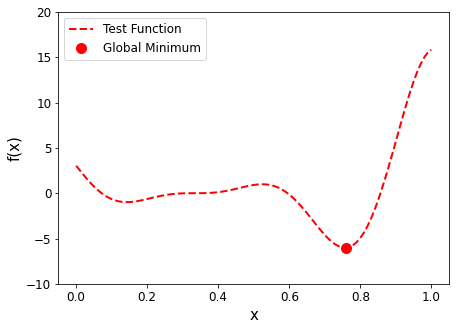

In [3]:
# Test function values
X_test = np.arange(0, 1.01, 0.01)
y_test = (X_test*6-2)**2*np.sin(X_test*12-4)

# Display test function
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])

# Display global minimum
min_index = np.argmin(y_test)
ax.plot(X_test[min_index],y_test[min_index],'ro',markerfacecolor='r',markersize=10,label='Global Minimum')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="upper left",prop={'size': 12});
plt.savefig('Test_function.png')

We can see that the function reaches the global minimum at $x=0.76$. 

### GP-based Surrogate Optimization

In practical settings, however, $f(x)$ has an unknown expression and can only be evaluated via a complicated, time-consuming computer simulation. Therefore, to reflect reality, in the following optimization process, we will:

- treat $f(x)$ as a black-box function;
- limit the number of $f(x)$ evaluations.

Those constraints rule out the feasibility of using a brute force approach to search for the global minimum. Instead, we will use the surrogate optimization strategy to achieve the goal.

The general workflow of the surrogate optimization is demonstrated below:
<img src="Workflow.png" width=500 height=300 />

#### 1. Initial GP model training
We kick-off the optimization procedure by training an initial GP model with 6 training samples. Here, the GP implementation from Scikit-learn is adopted to train the GP model.

In [5]:
# Initial training data
X_train = np.array([[0,0.1,0.2,0.4,0.6,1]]).T
y_train = (X_train*6-2)**2*np.sin(X_train*12-4)

In [6]:
# Train initial Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30, 
                                    alpha=1e-10, 
                                    normalize_y=True)
model.fit(X_train, y_train)

# GP prediction
y_pred, pred_std = model.predict(X_test.reshape((-1, 1)), return_std=True)

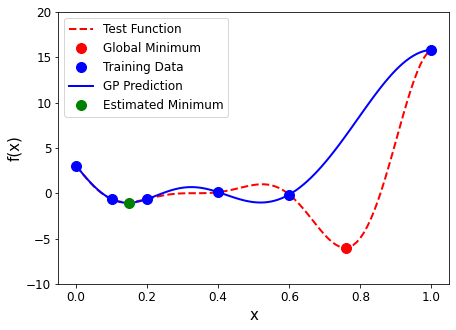

In [7]:
# Check GP prediction accuracy
ax.plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
ax.plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
ax.tick_params(axis='both', which='major', labelsize=12)

# 1-Find the current minimum
index = np.argmin(y_pred)
current_location = X_test[index]
current_objective = y_pred[index]
ax.plot(current_location,current_objective,'go',
        markerfacecolor='g',markersize=10,label='Estimated Minimum');
ax.legend(loc="upper left",prop={'size': 12});
fig.savefig('Initial_training.png')
fig

As we can see, the initially trained GP model has captured the wrong global minimum. The reason is obvious - the trained GP model predicts far off in the region of 0.6~1, where the actual global minimum locates. This simple test serves as a strong motivation to model refinement.

#### 2. Active Learning

To further improve the GP model accuracy in capturing the global minimum. We adopt an active learning strategy to iteratively refine the GP model. An illustration of the active learning concept is given below.

<img src="Active_Learning.png" width=500 height=300 />


At each learning iteration, we will look for a sample location $x^{\ast}$ such that it maximizes a pre-defined learning function. Subsequently, we calculate the true objective value $f(x^{\ast})$ and enrich the current training dataset with $[x^{\ast}, f(x^{\ast})]$. Finally, we update the GP model using the enriched dataset, thus completing one learning iteration.

#### 3. Expected Improvement Function

At any location $x$, the GP prediction $y(x)$ follows a normal distribution, i.e., $y(x) \sim  \mathcal{N}(\mu(x), \sigma^2(x))$. If $y(x)$ is smaller than the current minimum $y_{min}$, then there is a potential for *improvement*, as highlighted by the shaded area below.

<img src="Expected_Improvement.png" width=500 height=300 />

Naturally, we would be interested in identifying the location $x$ in the parameter space such that the associated improvement potential is the highest. It then makes intuitive sense to refine the GP model at location $x$, which would bring us one step closer to the true global minimum.

Quantitatively, we can define improvement $I$ in the following way:

\begin{equation}
  I(x) =
    \begin{cases}
      y_{min}-y(x) & \text{if} \; y(x)<y_{min}\\
      0 & \text{if} \ y(x) \geq y_{min}
    \end{cases} 
\end{equation}

Furthermore, we could calculate the expected value of $I(x)$ and use it to measure the improvement potential:

\begin{equation}
E[I(x)] = (y_{min}-\mu(x))\Phi \left (\frac{y_{min}-\mu(x)}{\sigma(x)} \right ) + \sigma(x)\phi \left (\frac{y_{min}-\mu(x)}{\sigma(x)} \right )
\end{equation}

where $\Phi(.)$ and $\phi(.)$ are the cumulative distribution function and probability density function of the normal distribution. The above equation for $E[I(x)]$ is the expected improvement function at location $x$.

#### 4. First Iteration
Let's see the first iteration.

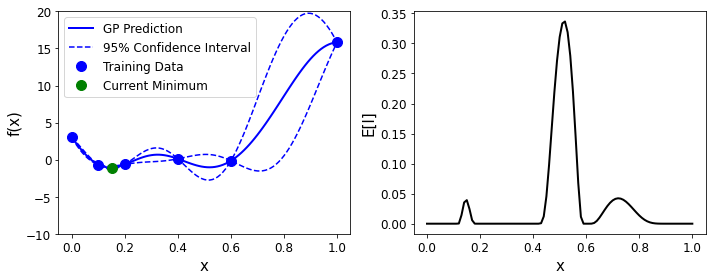

In [8]:
# Surrogate optimization based on Expected Improvement: EI visualization

# 2-Calculate expected improvement 
pred_std = pred_std.reshape(pred_std.shape[0], 1)
EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
        +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)

# 3-Post-processing
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(X_test,y_pred,'b-',linewidth=2,label='GP Prediction')
axs[0].plot(X_test,y_pred+1.95*pred_std,'b--',linewidth=1.5)
axs[0].plot(X_test,y_pred-1.95*pred_std,'b--',linewidth=1.5,label='95% Confidence Interval')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].plot(current_location,current_objective,'go',
        markerfacecolor='g',markersize=10,label='Current Minimum');
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_ylim([-10,20]);

axs[1].plot(X_test,EI,'k-',linewidth=2)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[I]', fontsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout();
fig.savefig('First_iteration.png')

On the right, we can see the distribution of $E[I(x)]$ over different x locations. A prominent spike is observed at $x=0.52$, indicating a high potential for improvement at that location. This makes sense as the GP prediction $\mu(x)$ at $x=0.52$ is fairly close to the current minimum, and the associated prediction standard deviation $\sigma(x)$ is rather large. Although $\sigma(x)$ is also large in the region of $x=0.6~1.0$, $\mu(x)$ is way much larger than the current minimum, therefore not much hope for finding improvements.

So, in this first iteration, we pick $x^{\ast}=0.52$ as the next sample.

#### 5. Further iterations

First, we define a `EI_Learning` function to perform any necessary calculations.

In [9]:
# Expected Improvement-based active learning function
def EI_learning(candidates, y_pred, pred_std):
    """Active learning function based on expected improvement
       
       This function selects a new sample from candidate pool to enrich the current training dataset.
       The sample gets selected if it has the maximum expected improvement value.
       
       Input: 
       - candidates: pool of candidates to select sample from
       - y_pred: GP predictions on candidate samples
       - pred_std: Standard deviation of the GP predictions on candidate samples
       
       Output:
       - new_sample: the selected sample with the maximum expected improvement value
       - EI: EI values of the candidate samples
    """
    
    # 1-Find the current minimum
    current_objective = y_pred[np.argmin(y_pred)]
    
    # 2-Calculate the EI values of the candidate samples
    pred_std = pred_std.reshape(pred_std.shape[0], 1)
    EI = (current_objective-y_pred)*st.norm.cdf((current_objective-y_pred)/pred_std) \
            +pred_std*st.norm.pdf((current_objective-y_pred)/pred_std)
    
    # 3-Select a new sample
    new_sample = candidates[np.argmax(EI)]
    
    return new_sample, EI

We pre-generated a large pool of candidate samples. For each iteration, we pick one sample from the candidate pool. This sample should yield the maximum expected improvement value among all the candidates.

In [10]:
# Surrogate optimization: iterations

# 0-Create candidate samples
candidates = np.arange(0, 1.01, 0.01)
iteration = 0

Then we can start iterating. **The following two cells can be excuted multiple times to manually control the iteration flow**. The first cell searches for the global optimum by gradually refining the GP model using expected improvement learning function. The second cell visually summarizes the results from the current iteration and add newly identified samples to the current training dataset.

In [21]:
# 1-GP model training and predicting
model.fit(X_train, y_train)
y_pred, pred_std = model.predict(candidates.reshape((-1, 1)), return_std=True)
y_test_pred, pred_test_std = model.predict(X_test.reshape((-1, 1)), return_std=True)
pred_test_std = pred_test_std.reshape(pred_test_std.shape[0], 1)

# 2-Calculate the current minimum
current_min = y_pred[np.argmin(y_pred),0]
location = candidates[np.argmin(y_pred)]

# 3-Select next sample
pred_std += 1e-8        # To prevent zero standard deviation value
new_sample, EI = EI_learning(candidates, y_pred, pred_std)

# 4-Calculate the true label of the new sample
y_sample = (new_sample*6-2)**2*np.sin(new_sample*12-4)

# 5-Display iteration info
summary = 'Iteration summary:'
iter_number = 'Current iteration: {}'.format(str(iteration))

Iteration_summary = 'Iteration {}:'.format(str(iteration)) \
                    + os.linesep \
                    + 'the current minimum is {}'.format(str(current_min)) \
                    + os.linesep \
                    + 'located at {}'.format(str(location))

print(Iteration_summary)

Iteration 3:
the current minimum is -6.016666662254233
located at 0.76


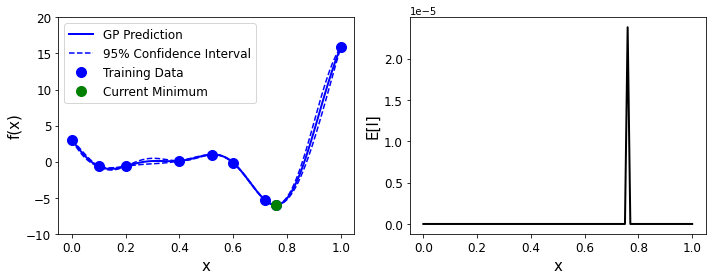

In [22]:
# 6-Iteration assessment
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(X_test,y_test_pred,'b-',linewidth=2,label='GP Prediction')
axs[0].plot(X_test,y_test_pred+1.95*pred_test_std,'b--',linewidth=1.5)
axs[0].plot(X_test,y_test_pred-1.95*pred_test_std,'b--',linewidth=1.5,label='95% Confidence Interval')
axs[0].plot(X_train,y_train,'bo',markerfacecolor='b',markersize=10,label='Training Data')
axs[0].set_xlabel('x', fontsize=15)
axs[0].set_ylabel('f(x)', fontsize=15)
axs[0].plot(location,current_min,'go',
        markerfacecolor='g',markersize=10,label='Current Minimum');
axs[0].legend(loc="upper left",prop={'size': 12})
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_ylim([-10,20]);

axs[1].plot(X_test,EI,'k-',linewidth=2)
axs[1].set_xlabel('x', fontsize=15)
axs[1].set_ylabel('E[I]', fontsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout();
fig.savefig('Later_iteration.png')

# 7-Enrich training dataset
X_train = np.vstack((X_train,new_sample))
y_train = np.vstack((y_train,y_sample))
iteration += 1

After 4 iterations, we can see that the current GP model makes high-confident predictions almost everywhere. Meanwhile, the maximum $E[I(x)]$ value has dropped to the order of $10^{-5}$, indicating that we've identified the global minimum. 

We do know its true global minimum for this test function, which exactly locates at $x^{\ast}=0.76$. Therefore,the GP-based surrogate optimization algorithm has successfully identified the global minimum.